In [ ]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import statistics 
from tqdm import tqdm

In [ ]:
fold1 = pd.read_excel('fold_1.xlsx')
fold2 = pd.read_excel('fold_2.xlsx')
fold3 = pd.read_excel('fold_3.xlsx')
fold4 = pd.read_excel('fold_4.xlsx')
fold5 = pd.read_excel('fold_5.xlsx')

In [ ]:
traindf = pd.concat([fold5, fold1,fold3,fold2], axis=0, sort=False)
testdf = fold4

In [ ]:
X_train = np.array(traindf.iloc[:,3:57])
y_train = np.array(traindf.iloc[:,57]).reshape(-1)

In [ ]:
X_train = torch.tensor(X_train, device="cuda").type(torch.float)
y_train = torch.tensor(y_train, device="cuda").type(torch.float)

In [ ]:
X_mean = X_train.mean(dim=0)
X_std = X_train.std(dim=0)
y_mean = y_train.mean(dim=0)
y_std = y_train.std(dim=0)
X_mean.shape, X_std.shape, y_mean.shape, y_std.shape

(torch.Size([54]), torch.Size([54]), torch.Size([]), torch.Size([]))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        super().__init__()
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        if self.target_transform is not None:
            y = self.target_transform(y)
        return X, y

In [ ]:
training_set = CustomDataset(X_train, 
                             y_train, 
                             transform=lambda X: ((X - X_mean)/X_std), 
                             target_transform=lambda y: ((y - y_mean)/y_std)
                          )



In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(54, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(256, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),  
    torch.nn.Dropout(p=0.1),   
    torch.nn.Linear(512, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),  
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(256, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.ReLU(),  
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(128, 64),
    torch.nn.BatchNorm1d(64),
    torch.nn.ReLU(),  
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(64, 1))

batch_size = 128
epoch_total = 100


def lr_lambda(epoch):
 
    lr=0.01    
    return lr

optimizer = torch.optim.Adam([param for param in net.parameters() if param.requires_grad], lr=0.01, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

loss_func = torch.nn.MSELoss(reduction="none") 

train_loader = DataLoader(
    dataset=training_set,
    batch_size=batch_size, 
    shuffle=True)



net = net.cuda()

train_losses = []
train_r2 = []
# start training

for epoch in range(epoch_total):
    # print('Epoch = %d' % epoch + 1)
    net.train()
    train_targets = []
    train_predictions = []
    total_loss = None
    for step, (batch_X, batch_y) in enumerate(train_loader): # for each training step
        optimizer.zero_grad()   # clear gradients for next train
        prediction = net(batch_X).squeeze(dim=1) 
          # input x and predict based on x
        loss = loss_func(prediction, batch_y)     # must be (1. nn output, 2. target)
        current_loss = loss.sum()

        if total_loss is None:
            total_loss = current_loss
        else:
            total_loss += current_loss
        
        loss = loss.mean()
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        train_targets += [batch_y]
        train_predictions += [prediction]
    
    with torch.no_grad():
        train_targets = torch.cat(train_targets, dim=0)
        train_predictions = torch.cat(train_predictions, dim=0)
        total_loss = total_loss / train_targets.shape[0]
        train_losses += [total_loss.item()]
        train_r2.append(sklearn.metrics.r2_score((train_targets * y_std + y_mean).cpu().numpy(), (train_predictions * y_std + y_mean).cpu().numpy()))
        print('Epoch %d: Training Loss = %.4f' % (epoch + 1, total_loss.item()))


    lr_scheduler.step()


Epoch 1: Training Loss = 0.3184
Epoch 2: Training Loss = 0.1844
Epoch 3: Training Loss = 0.1561
Epoch 4: Training Loss = 0.1387
Epoch 5: Training Loss = 0.1290
Epoch 6: Training Loss = 0.1221
Epoch 7: Training Loss = 0.1173
Epoch 8: Training Loss = 0.1121
Epoch 9: Training Loss = 0.1091
Epoch 10: Training Loss = 0.1035
Epoch 11: Training Loss = 0.1022
Epoch 12: Training Loss = 0.1000
Epoch 13: Training Loss = 0.0945
Epoch 14: Training Loss = 0.0949
Epoch 15: Training Loss = 0.0917
Epoch 16: Training Loss = 0.0901
Epoch 17: Training Loss = 0.0879
Epoch 18: Training Loss = 0.0880
Epoch 19: Training Loss = 0.0869
Epoch 20: Training Loss = 0.0846
Epoch 21: Training Loss = 0.0821
Epoch 22: Training Loss = 0.0831
Epoch 23: Training Loss = 0.0789
Epoch 24: Training Loss = 0.0800
Epoch 25: Training Loss = 0.0761
Epoch 26: Training Loss = 0.0777
Epoch 27: Training Loss = 0.0762
Epoch 28: Training Loss = 0.0760
Epoch 29: Training Loss = 0.0753
Epoch 30: Training Loss = 0.0738
Epoch 31: Training 

In [ ]:
X_test = np.array(testdf.iloc[:,3:57])
y_test = np.array(testdf.iloc[:,57]).reshape(-1)

In [ ]:
X_test = torch.tensor(X_test, device="cuda").type(torch.float)
y_test = torch.tensor(y_test, device="cuda").type(torch.float)

In [ ]:
test_set = CustomDataset(X_test,
                        y_test,
                        transform=lambda X: ((X - X_mean)/X_std), 
                        target_transform=lambda y: ((y - y_mean)/y_std)
                    )

In [ ]:
test_r2=[]
test_losses=[]

In [ ]:
test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size, 
    shuffle=False)

with torch.no_grad():
    net.eval()
    test_targets = []
    test_predictions = []
    total_loss = None
    for (batch_X, batch_y) in test_loader: # for each training step
        prediction = net(batch_X).squeeze(dim=1)     # input x and predict based on x
        current_loss = loss_func(prediction, batch_y).sum()
        if total_loss is None:
            total_loss = current_loss
        else:
            total_loss += current_loss
        test_targets += [batch_y]
        test_predictions += [prediction]
    test_targets = torch.cat(test_targets, dim=0)
    test_predictions = torch.cat(test_predictions, dim=0)
    test_r2.append(sklearn.metrics.r2_score((test_targets * y_std + y_mean).cpu().numpy(), (test_predictions * y_std + y_mean).cpu().numpy()))
    
    total_loss = total_loss / test_targets.shape[0]
    test_losses.append(total_loss.item())
    print("Epoch %d: Validation Loss = %.4f" % (epoch + 1, total_loss.item()))

Epoch 100: Validation Loss = 0.0441


In [ ]:
test_r2

[0.9343098760192898]

In [ ]:
train_r2[len(train_r2)-1]

0.948699779542703

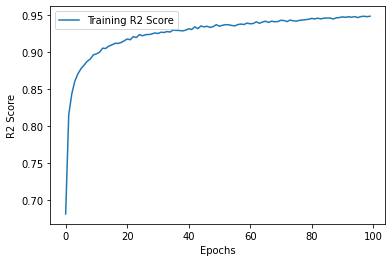

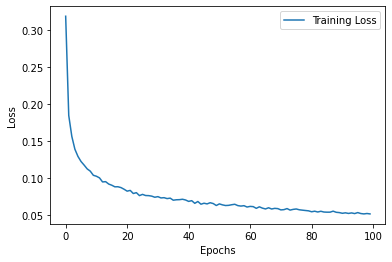

In [ ]:
plt.plot(train_r2, label="Training R2 Score")
plt.ylabel('R2 Score')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.plot(train_losses, label="Training Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

(-3.0, 15.0)

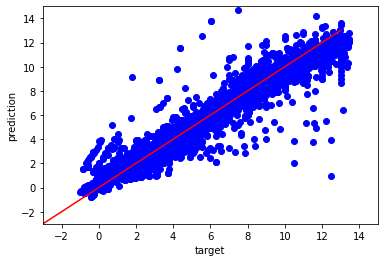

In [ ]:
plt.plot((test_targets * y_std + y_mean).cpu().numpy(), (test_predictions * y_std + y_mean).cpu().numpy(),'bo')
plt.plot([-3,13],[-3,13],'red')
plt.ylabel('prediction')
plt.xlabel('target')
plt.xlim(-3, 15)
plt.ylim(-3, 15)

In [ ]:
import tensorflow as tf

(-3.0, 15.0)

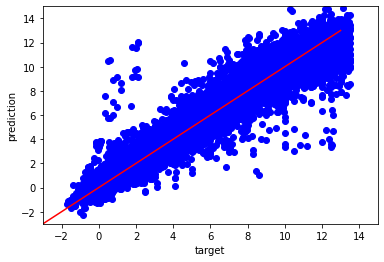

In [ ]:
plt.plot((train_targets * y_std + y_mean).cpu().numpy(), (train_predictions * y_std + y_mean).cpu().numpy(),'bo')
plt.plot([-3,13],[-3,13],'red')
plt.ylabel('prediction')
plt.xlabel('target')
plt.xlim(-3, 15)
plt.ylim(-3, 15)

In [ ]:
diff = (((test_targets * y_std + y_mean).cpu().numpy()) - ((test_predictions * y_std + y_mean).cpu().numpy()))
diff = abs(diff)
outliers = list(np.array(np.where((abs(diff) - np.mean(diff))/np.std(diff) >2 )).reshape(-1))
outlierdf = testdf.iloc[outliers,]
outlierdf.to_excel('outlierdf4.xlsx')
from google.colab import files
files.download('outlierdf4.xlsx') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>